In [20]:
# load libraries
suppressWarnings(suppressPackageStartupMessages(library(limma)))
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(scran)))
suppressWarnings(suppressPackageStartupMessages(library(ComplexHeatmap)))
suppressWarnings(suppressPackageStartupMessages(library(circlize)))
suppressWarnings(suppressPackageStartupMessages(library(ggthemes)))

In [2]:
sce = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.rds")

In [3]:
sce

class: SingleCellExperiment 
dim: 11231 36044 
metadata(4): log.exprs.offset log.exprs.offset log.exprs.offset
  log.exprs.offset
assays(3): tpm counts logcounts
rownames(11231): ENSG00000000003_TSPAN6 ENSG00000000419_DPM1 ...
  ENSG00000272325_NUDT3 ENSG00000272398_CD24
rowData names(17): exprs_collapsed_to ensembl_transcript_id ...
  is_intop2000hvg is_hvg
colnames(36044): 21843_1#10 21843_1#100 ... 24539_8#97 24539_8#98
colData names(123): adj_x adj_y ... princ_curve princ_curve_scaled01
reducedDimNames(1): PCA
spikeNames(1): ERCC

In [4]:
## HVGs (highly variable genes)
sce = normalize(sce)
design = model.matrix(~ experiment, data = colData(sce))
alt.fit = trendVar(sce, design = design, use.spikes = FALSE)
alt.decomp = decomposeVar(sce, alt.fit)

Warning message in .local(object, ...):
“spike-in transcripts in 'ERCC' should have their own size factors”

In [5]:
hvgs <- rownames(alt.decomp[alt.decomp$FDR < 0.01,])
rowData(sce)$is_hvg <- (rownames(sce) %in% hvgs)

In [6]:
length(hvgs)

[1] 4546

`geom_smooth()` using method = 'gam'


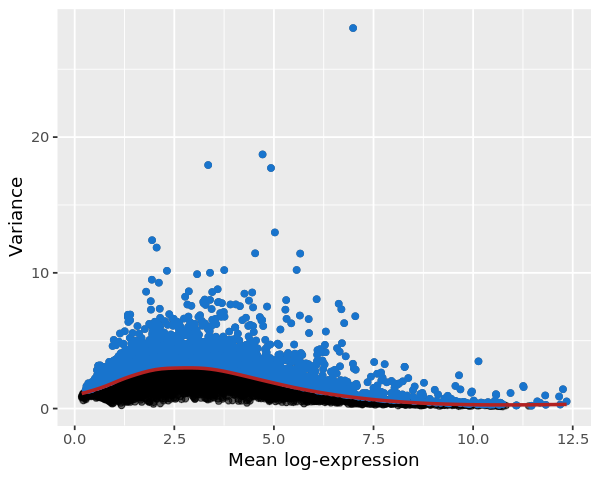

In [7]:
options(repr.plot.width = 5, repr.plot.height = 4)
vardecomp <-  data.frame(mean = alt.decomp$mean, total = alt.decomp$total,
           tech = alt.decomp$tech, bio = alt.decomp$bio)
ggplot(vardecomp, aes(x = mean, y = total)) +
    geom_point(alpha = 0.6) +
    geom_point(aes(x = mean, y = total), colour = "dodgerblue3",
               data = dplyr::filter(vardecomp, bio >= 0.1 * tech)) +
    geom_smooth(aes(x = mean, y = tech), colour = "firebrick") +
    ylab("Variance") + xlab("Mean log-expression")

In [8]:
### pseudotime and stages (ideally already in sceset)

In [9]:
top.500hvgs = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),])[1:500]
rowData(sce)$is_intop500hvg <- (rownames(sce) %in% top.500hvgs)
pca.500hvgs = prcomp(t(logcounts(sce[rowData(sce)$is_intop500hvg,])))$x
sce$PC1_top500hvgs = pca.500hvgs[,1]
# some cells will not be assigned to any stage
sce$stage = "not assigned"
# just assign all day0 cells to ips
sce[,sce$day == "day0"]$stage = "ips"
# still based on not scale PC1, since those are the criteria used for eQTLs
sce[,sce$PC1_top500hvgs  > -23 & sce$PC1_top500hvgs < 4 & sce$day %in% c("day1","day2")]$stage = "mesendo"
sce[,sce$PC1_top500hvgs  > 22 & sce$day %in% c("day2","day3")]$stage = "defendo"
sce$pseudotime = sce$PC1_top500hvgs

In [10]:
sce_hvg = sce[rowData(sce)$is_hvg,] # use all highly variable genes 
sce_hvg = sce_hvg[,order(sce$pseudotime)] # order by pseudotime
pheno = logcounts(sce_hvg)
pheno[1:5,1:10]

,25476_4#161,24842_6#140,25476_4#261,25619_7#213,25619_7#290,24475_3#217,25476_4#375,25476_4#363,25475_7#166,25476_4#348
ENSG00000001626_CFTR,0.000000,0.000000,3.54343903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000001631_KRIT1,3.881098,4.968258,0.02938662,2.019067,0.000000,1.624508,4.054391,2.964503,3.101980,3.580990
ENSG00000002330_BAD,5.635139,6.035284,0.00000000,5.818258,6.696320,7.254389,3.061580,5.743200,6.851853,5.810500
ENSG00000002586_CD99,4.689640,4.748486,4.67782549,5.490188,5.626717,5.459356,4.236858,5.874729,2.467503,4.981735
ENSG00000002822_MAD1L1,3.327948,1.456564,2.17822331,4.118308,0.000000,2.495555,3.789074,4.460200,2.544673,4.500194


In [11]:
##### find genes differentially expressed from day to day

In [12]:
# define matrix, counts
mat = as.data.frame(cbind(sce_hvg$day, t(logcounts(sce_hvg))))
colnames(mat)[1] <- "day"
# design matrix, day
design <- model.matrix(~ 0 + day, data = mat)
colnames(design) = paste0("day",0:3)
design = cbind(1,design)
colnames(design)[1] = "Intercept"
dim(design)
head(design)

[1] 36044     5

,Intercept,day0,day1,day2,day3
25476_4#161,1,1,0,0,0
24842_6#140,1,1,0,0,0
25476_4#261,1,1,0,0,0
25619_7#213,1,1,0,0,0
25619_7#290,1,1,0,0,0
24475_3#217,1,1,0,0,0


In [13]:
# only numeric
matnum <- matrix(as.numeric(unlist(mat[,-1])), nrow = nrow(mat), ncol = ncol(mat)-1)
rownames(matnum) <- rownames(mat)
colnames(matnum) <- colnames(mat)[-1]
dim(t(matnum))

[1]  4546 36044

In [14]:
# top 50 genes DE between day0 and all other days
mylm_0 = lmFit(t(matnum), design[,c("Intercept","day0")])
fit_0 <- eBayes(mylm_0, trend = TRUE)
df_fit_0 = as.data.frame(fit_0$coefficients)
genes_day0 = rownames(head(df_fit_0[order(df_fit_0$day0, decreasing = T),],50))
# also day1
mylm_1 = lmFit(t(matnum), design[,c("Intercept","day1")])
fit_1 <- eBayes(mylm_1, trend = TRUE)
df_fit_1 = as.data.frame(fit_1$coefficients)
genes_day1 = rownames(head(df_fit_1[order(df_fit_1$day1, decreasing = T),],50))
# day2
mylm_2 = lmFit(t(matnum), design[,c("Intercept","day2")])
fit_2 <- eBayes(mylm_2, trend = TRUE)
df_fit_2 = as.data.frame(fit_2$coefficients)
genes_day2 = rownames(head(df_fit_2[order(df_fit_2$day2, decreasing = T),],50))
# day3
mylm_3 = lmFit(t(matnum), design[,c("Intercept","day3")])
fit_3 <- eBayes(mylm_3, trend = TRUE)
df_fit_3 = as.data.frame(fit_3$coefficients)
genes_day3 = rownames(head(df_fit_3[order(df_fit_3$day3, decreasing = T),],50))
# take the union of all those genes
genes_days = c(genes_day0, genes_day1, genes_day2, genes_day3)

In [15]:
# select relevant genes to show
mat = pheno[rownames(pheno) %in% unique(genes_days),]

In [16]:
# scale matrix (each row)
mat_scaled = t(apply(mat, 1, scale))

In [17]:
## genes to annotate
genes_sel = c('NANOG','T','GATA6')
subset = which(gsub(".*_","",rownames(mat)) %in% genes_sel)
labels = gsub(".*_","",rownames(mat)[subset])

In [18]:
range01 <- function(x){(x-min(x))/(max(x)-min(x))}

In [21]:
col_day0 = canva_pal("Pool party")(4)[1]
col_day1 = canva_pal("Pool party")(4)[2]
col_day2 = canva_pal("Pool party")(4)[3]
col_day3 = canva_pal("Pool party")(4)[4]

col_ips = canva_pal("Modern and clean")(4)[2]
col_mesendo = canva_pal("Modern and clean")(4)[4]
col_defendo = canva_pal("Warm tones")(4)[3]

# col_ips = "cornflowerblue"
# col_mesendo = "forestgreen"
# col_defendo = "coral"

In [22]:
## annotations
ha_top = HeatmapAnnotation(df = data.frame(stage = sce_hvg$stage), 
    col = list(stage = c("ips" = col_ips, "mesendo" = col_mesendo, "defendo" = col_defendo,
                        "not assigned" = "grey"))) # col anno3

ha_bottom = HeatmapAnnotation(df = data.frame(pseudotime = range01(sce_hvg$PC1_top500hvgs), # annotation 1
                                              day = sce_hvg$day), # annotation 2
    gap = unit(c(1.5), "mm"),
    col = list(pseudotime = colorRamp2(c(0,1), c("white", "darkblue")), # col anno1
               day = c("day0" =  col_day0, "day1" = col_day1, "day2" = col_day2, "day3" = col_day3)))# col anno2

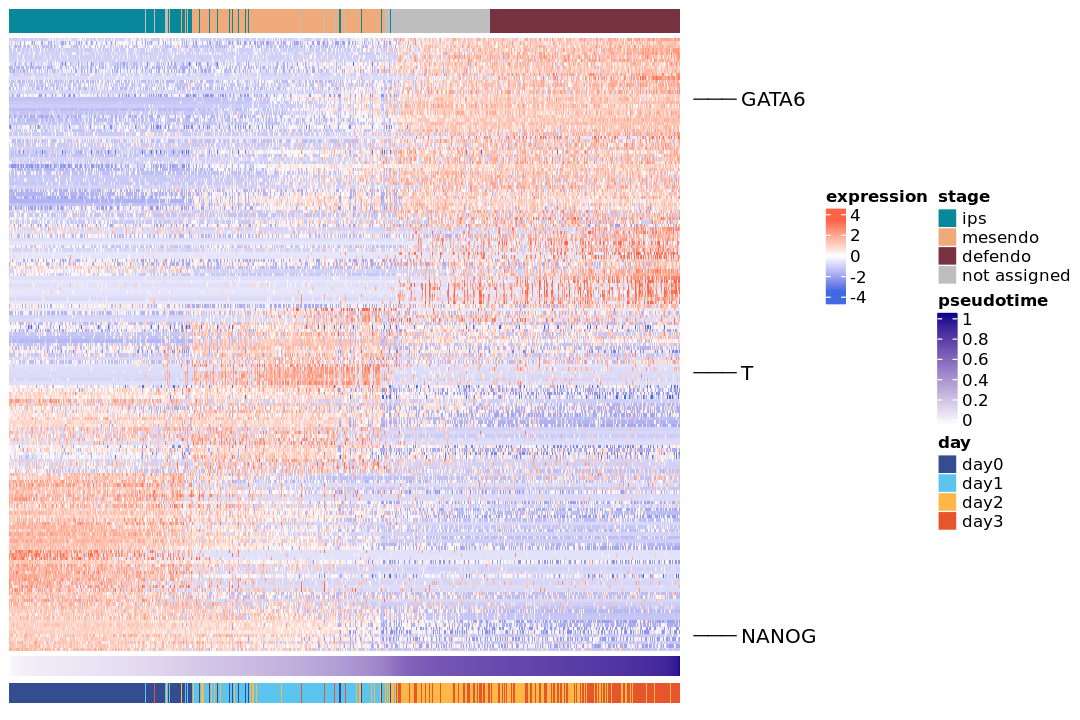

In [23]:
options(repr.plot.width = 9, repr.plot.height = 6)
Heatmap(mat_scaled,  show_column_names = FALSE, show_row_names = FALSE, show_row_dend = FALSE,
        name = "expression", 
        col = colorRamp2(c(-3, 0, 3), c("royalblue", "white", "tomato")),
        top_annotation = ha_top,
        bottom_annotation = ha_bottom,
        cluster_columns = FALSE, clustering_distance_rows = "spearman") + 
rowAnnotation(link = row_anno_link(at = subset, labels = labels),
  width = unit(1, "cm") + max_text_width(labels))

In [ ]:
####### add Supplementary Fig 19

In [33]:
a11 = length(genes_day0)
a12 = length(genes_day0[genes_day0 %in% genes_day1])
a13 = length(genes_day0[genes_day0 %in% genes_day2])
a14 = length(genes_day0[genes_day0 %in% genes_day3])
a22 = length(genes_day1)
a23 = length(genes_day1[genes_day1 %in% genes_day2])
a24 = length(genes_day1[genes_day1 %in% genes_day3])
a33 = length(genes_day2)
a34 = length(genes_day2[genes_day2 %in% genes_day3])
a44 = length(genes_day3)

In [34]:
mat = matrix(rbind(c(a11, a12, a13, a14),
                   c(a12, a22, a23, a24),
                   c(a13, a23, a33, a34),
                   c(a14, a24, a34, a44)), ncol = 4)
mat

50,2,0,0
2,50,3,0
0,3,50,20
0,0,20,50


In [35]:
rownames(mat) = paste0("day",0:3)
colnames(mat) = paste0("day",0:3)

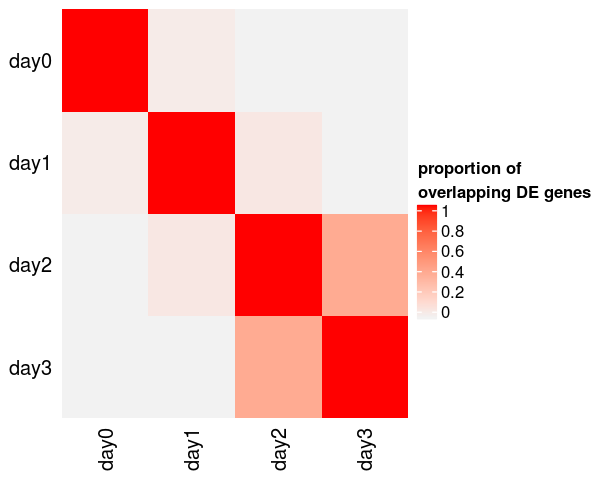

In [36]:
options(repr.plot.width = 5, repr.plot.height = 4)
Heatmap(mat/50, cluster_columns = FALSE, cluster_rows = FALSE, name = "proportion of \noverlapping DE genes",
       col = colorRamp2(c(0, 1), c("gray95", "red")), row_names_side = "left")